In [ ]:
# Importing necessary libraries for EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

# Importing libraries necessary for Model Building and Training
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Loading Dataset

In [ ]:
data = pd.read_csv('emails.csv')
data.head()


,Email No.,the,to,ect,and,for,of,a,you,hou,...,connevey,jay,valued,lay,infrastructure,military,allowing,ff,dry,Prediction
0,Email 1,0,0,1,0,0,0,2,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Email 2,8,13,24,6,6,2,102,1,27,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,Email 3,0,0,1,0,0,0,8,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Email 4,0,5,22,0,5,1,51,2,10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Email 5,7,6,17,1,5,2,57,0,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


To check how many such tweets data we have let’s print the shape of the data frame.

In [ ]:
data.shape


(344, 3002)

For a better understanding, we’ll plot these counts:

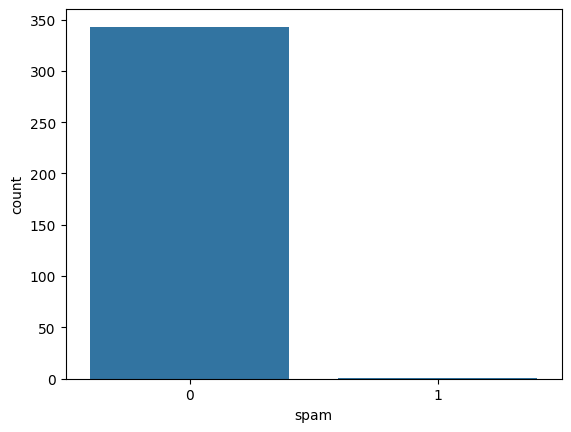

In [ ]:
sns.countplot(x='spam', data=data)
plt.show()


We can clearly see that number of samples of Ham is much more than that of Spam which implies that the dataset we are using is imbalanced.

Text(0.5, 0, 'Message types')

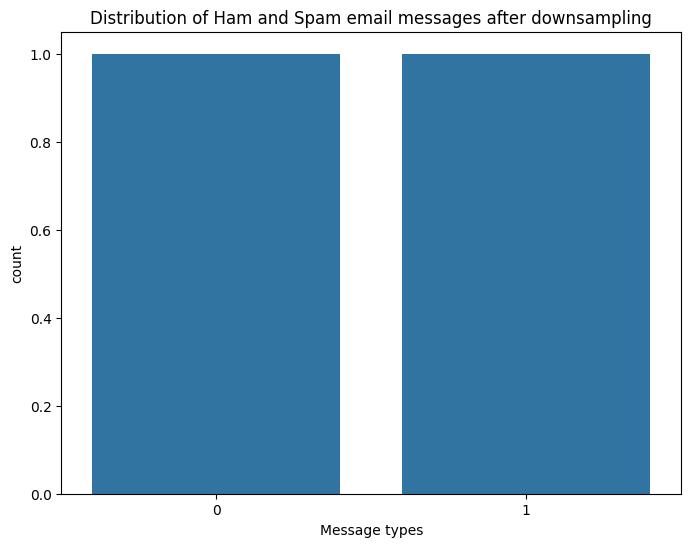

In [ ]:
# Downsampling to balance the dataset
ham_msg = data[data.spam == 0]
spam_msg = data[data.spam == 1]
ham_msg = ham_msg.sample(n=len(spam_msg),
                        random_state=42)

# Plotting the counts of down sampled dataset
balanced_data = pd.concat([ham_msg, spam_msg]).reset_index(drop=True) # Use pd.concat to combine DataFrames
plt.figure(figsize=(8, 6))
sns.countplot(data = balanced_data, x='spam')
plt.title('Distribution of Ham and Spam email messages after downsampling')
plt.xlabel('Message types')


Text Preprocessing
Textual data is highly unstructured and need attention in many aspects:

Stopwords Removal
Punctuations Removal
Stemming or Lemmatization
Although removing data means loss of information we need to do this to make the data perfect to feed into a machine learning model.

In [ ]:
# Convert the 'text' column to string type
balanced_data['text'] = balanced_data['text'].astype(str)

# Now you can use the .str accessor
balanced_data['text'] = balanced_data['text'].str.replace('Subject', '')
balanced_data.head()

,Email No.,the,to,ect,and,for,of,a,you,hou,...,connevey,jay,valued,lay,infrastructure,military,allowing,ff,dry,Prediction
0,Email 239,13,9,1,13,5,5,87,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Email 150,5,11,1,2,2,5,49,11,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
punctuations_list = string.punctuation
def remove_punctuations(text):
	temp = str.maketrans('', '', punctuations_list)
	return text.translate(temp)

balanced_data['text']= balanced_data['text'].apply(lambda x: remove_punctuations(x))
balanced_data.head()


,Email No.,the,to,ect,and,for,of,a,you,hou,...,connevey,jay,valued,lay,infrastructure,military,allowing,ff,dry,Prediction
0,Email 239,13,9,1,13,5,5,87,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Email 150,5,11,1,2,2,5,49,11,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
def remove_stopwords(text):
	stop_words = stopwords.words('english')

	imp_words = []

	# Storing the important words
	for word in str(text).split():
		word = word.lower()

		if word not in stop_words:
			imp_words.append(word)

	output = " ".join(imp_words)

	return output


balanced_data['text'] = balanced_data['text'].apply(lambda text: remove_stopwords(text))
balanced_data.head()


,Email No.,the,to,ect,and,for,of,a,you,hou,...,connevey,jay,valued,lay,infrastructure,military,allowing,ff,dry,Prediction
0,Email 239,13,9,1,13,5,5,87,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Email 150,5,11,1,2,2,5,49,11,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')
    imp_words = []

    # Handle the case where 'text' might be empty or None
    if text is not None:
        for word in str(text).split():
            word = word.lower()
            if word not in stop_words:
                imp_words.append(word)

    # Return an empty string if no important words are found, otherwise join them
    return " ".join(imp_words) if imp_words else ""

# Apply the updated remove_stopwords function
balanced_data['text'] = balanced_data['text'].apply(lambda text: remove_stopwords(text))


Word2Vec Conversion

In [ ]:
#train test split
train_X, test_X, train_Y, test_Y = train_test_split(balanced_data['text'],
													balanced_data['spam'],
													test_size = 0.2,
													random_state = 42)


We have fitted the tokenizer on our training data we will use it to convert the training and validation data both to vectors.

In [ ]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

# Pad sequences to have the same length
max_len = 100 # maximum sequence length
train_sequences = pad_sequences(train_sequences,
								maxlen=max_len,
								padding='post',
								truncating='post')
test_sequences = pad_sequences(test_sequences,
							maxlen=max_len,
							padding='post',
							truncating='post')


Model Development and Evaluation

In [ ]:
# Build the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1,
									output_dim=32,
									input_length=max_len))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           64        
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 32)                544       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3777 (14.75 KB)
Trainable params: 3777 (14.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


While compiling a model we provide these three essential parameters:

optimizer – This is the method that helps to optimize the cost function by using gradient descent.
loss – The loss function by which we monitor whether the model is improving with training or not.
metrics – This helps to evaluate the model by predicting the training and the validation data.

In [ ]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
			metrics = ['accuracy'],
			optimizer = 'adam')


Callback

In [ ]:
es = EarlyStopping(patience=3,
				monitor = 'val_accuracy',
				restore_best_weights = True)

lr = ReduceLROnPlateau(patience = 2,
					monitor = 'val_loss',
					factor = 0.5,
					verbose = 0)


Let us now train the model:

In [ ]:
# Train the model
history = model.fit(train_sequences, train_Y,
					validation_data=(test_sequences, test_Y),
					epochs=20,
					batch_size=32,
					callbacks = [lr, es]
				)


Epoch 1/20
1/1 [==============================] - 4s 4s/step - loss: 0.6935 - accuracy: 0.0000e+00 - val_loss: 0.6981 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/20
1/1 [==============================] - 0s 89ms/step - loss: 0.6882 - accuracy: 1.0000 - val_loss: 0.7036 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/20
1/1 [==============================] - 0s 77ms/step - loss: 0.6828 - accuracy: 1.0000 - val_loss: 0.7094 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/20
1/1 [==============================] - 0s 100ms/step - loss: 0.6771 - accuracy: 1.0000 - val_loss: 0.7119 - val_accuracy: 0.0000e+00 - lr: 5.0000e-04


Now, let’s evaluate the model on the validation data.

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)


1/1 [==============================] - 0s 33ms/step - loss: 0.6981 - accuracy: 0.0000e+00
Test Loss : 0.6981409788131714
Test Accuracy : 0.0


Model Evaluation Results
Having trained our model, we can plot a graph depicting the variance of training and validation accuracies with the no. of epochs.

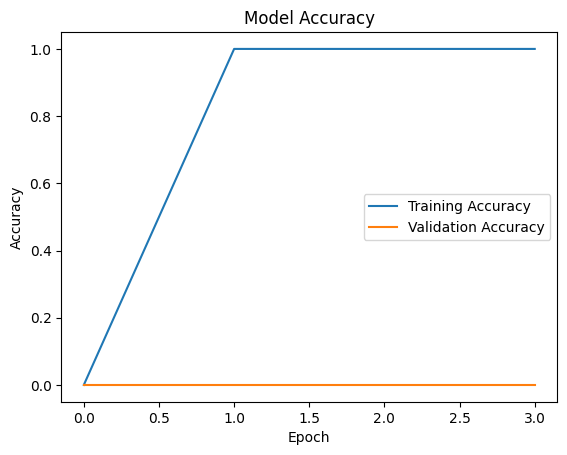

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()
